In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import eli5

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

from sklearn.feature_extraction.text import TfidfVectorizer

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import sklearn.metrics as metrics

from gensim import utils
import gensim.parsing.preprocessing as gsp

import joblib

# Functions

# Load data

In [2]:
# Read csv and create list of tags 
df = pd.read_csv('in/StackOverflow_50000_posts.csv')
df = df[['Id', 'Title', 'Body', 'Tags']]

df['Post'] = df['Title'] + ' ' + df['Body']
df.drop(columns = ['Title', 'Body'], inplace = True)

df['Tags'] = df['Tags'].str.findall(r'<(.*?)>')
df['nTags'] = df['Tags'].apply(len)

In [3]:
df = df.loc[0:1999, :]
n_posts = df['Id'].count()

In [4]:
# Create tags matrix of size n_obs * n_tags
mlb = MultiLabelBinarizer(sparse_output = False)
df_tags = pd.DataFrame(mlb.fit_transform(df['Tags']), columns = mlb.classes_, index = df.index)

# Analyze tags

In [5]:
# Sort df_tags per number of occurences 
df_tags_unique = pd.DataFrame(df_tags.sum(axis = 0).sort_values(ascending = False), columns = ['n_occurence'])
df_tags = df_tags[df_tags_unique.index]

In [6]:
# Calculate cumulative percentage of tags
n_total_tags = df_tags.sum().sum()
df_tags_unique['pct_tags'] = df_tags_unique.cumsum(axis = 0) / n_total_tags * 100
n_total_tags

6075

In [7]:
# Calculate what % of posts are covered by at least one tag 
df_tmp = pd.DataFrame(index = df_tags.index, columns = ['Tagged'])
df_tmp['Tagged'] = 0

for col in df_tags:
    df_tmp['Tagged'] = df_tmp['Tagged'] | df_tags[col]
    df_tags_unique.loc[col, 'n_posts'] = df_tmp['Tagged'].sum()
    
df_tags_unique['pct_posts'] = df_tags_unique['n_posts'] / n_posts * 100

# Reset index to create tag col
df_tags_unique = df_tags_unique.reset_index().rename(columns = {'index': 'tag'})

n_tags_unique = df_tags_unique['tag'].count()
n_tags_unique

2104

In [8]:
df_tags_unique

,tag,n_occurence,pct_tags,n_posts,pct_posts
0,python,340,5.596708,340.0,17.00
1,javascript,186,8.658436,525.0,26.25
2,java,161,11.308642,683.0,34.15
3,r,106,13.053498,788.0,39.40
4,c#,95,14.617284,882.0,44.10
...,...,...,...,...,...
2099,ngxs,1,99.934156,2000.0,100.00
2100,ngzone,1,99.950617,2000.0,100.00
2101,nlog,1,99.967078,2000.0,100.00
2102,node-schedule,1,99.983539,2000.0,100.00


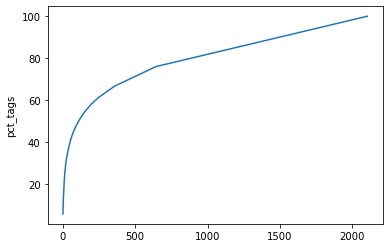

In [9]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_tags'])

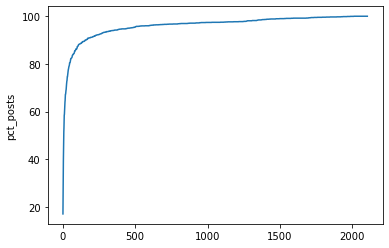

In [10]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_posts'])

In [11]:
df_tags_unique.loc[19, :]

tag             arrays
n_occurence         35
pct_tags       29.2181
n_posts           1352
pct_posts         67.6
Name: 19, dtype: object

# Modelling

## Select subset of tags to create train and test set

In [12]:
list_top = df_tags_unique.loc[0:19, 'tag']

df_tags = df_tags[list_top]

keep_index = df_tags[df_tags.sum(axis = 1) != 0].index

X = df.loc[keep_index, 'Post']
y = df_tags.loc[keep_index, :]

# train = 50%, val = 25%, test = 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

X_train_tmp, X_val, y_train_tmp, y_val = train_test_split(X_train, y_train, test_size = 1/3, random_state = 0)

# When working with a validation set in GridSearchCV, we can use a predefined split instead of k-folds
split_index = [0 if x in X_val.index else -1 for x in X_train.index]
pds = PredefinedSplit(test_fold = split_index)

## Create pipeline

In [13]:
# Define and apply gensim filters
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
#            gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

# Custom transformer using gensim filters
class TextCleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [49]:
models = [
#     RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 457), 
    xgb.XGBClassifier(objective = 'binary:logistic', n_jobs = -1, random_state = 457)
]

# RF
max_depth_rf = np.arange(10,30)
max_features_rf = [0.8, 'auto', 'sqrt']
min_samples_split_rf = [2, 4, 10]

# XGBoost
n_estimators_xgb = [100, 200]
max_depth_xgb = [5, 10, 15]
learning_rate_xgb = [0.1]
gamma_xgb = [0]
reg_lambda_xgb = [1]

param_grid = [
    # XGBoost uniquement
    {'model__classifier__n_estimators': n_estimators_xgb,
     'model__classifier__max_depth': max_depth_xgb, 
     'model__classifier__learning_rate': learning_rate_xgb, 
     'model__classifier__gamma': gamma_xgb, 
     'model__classifier__reg_lambda': reg_lambda_xgb
    }
]

In [50]:
%%time

for i in range(0, len(models)):
    clf = BinaryRelevance(classifier = models[i], require_dense = [True, True])
    pip = Pipeline([('clean', TextCleaner()),
                    ('vect', TfidfVectorizer()),
                    ('model', clf)])
    
    pip_cv = GridSearchCV(pip, param_grid[i], cv = pds, scoring = 'jaccard_weighted', iid = False)
    pip_cv.fit(X_train, y_train)
    
    print('Model :', models[i])
    print('Cross Validation best score :', pip_cv.best_score_)
    print('Cross Validation best params :', pip_cv.best_params_)
    
    # Get results on test set
    y_proba = pip_cv.predict_proba(X_test)
    y_proba = pd.DataFrame(y_proba.toarray(), columns = y_test.columns, index = y_test.index)
    
    jaccard_max = 0
    f1_max = 0
    decision_threshold_max = 0
    
    for i in np.arange(0, 10, 1):
        decision_threshold = i / 10
        
        jaccard = metrics.jaccard_score(y_test, y_proba > decision_threshold, average = 'weighted')
        
        if jaccard > jaccard_max:
            jaccard_max = jaccard
            f1_max = metrics.f1_score(y_test, y_proba > decision_threshold, average = 'weighted')
            decision_threshold_max = decision_threshold
    
    print('Test results :')
    print('Jaccard :', jaccard_max)
    print('F1 :', f1_max)
    print('decision_threshold :', decision_threshold_max)
    print()

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


OSError: [WinError -529697949] Windows Error 0xe06d7363

In [51]:
pip_cv.cv_results_

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
pip_cv.n_splits_

In [ ]:
joblib.dump(pip_cv, 'supervised_model.pkl')

# Load trained model

In [14]:
pip_cv = joblib.load('supervised_model.pkl')

In [18]:
print('Model :', pip_cv.best_estimator_['model'])
print('Cross Validation best score :', pip_cv.best_score_)
print('Cross Validation best params :', pip_cv.best_params_)

# Get results on test set
y_proba = pip_cv.predict_proba(X_test)
y_proba = pd.DataFrame(y_proba.toarray(), columns = y_test.columns, index = y_test.index)

jaccard_max = 0
f1_max = 0
decision_threshold_max = 0

for i in np.arange(0, 10, 1):
    decision_threshold = i / 10

    jaccard = metrics.jaccard_score(y_test, y_proba > decision_threshold, average = 'weighted')

    if jaccard > jaccard_max:
        jaccard_max = jaccard
        f1_max = metrics.f1_score(y_test, y_proba > decision_threshold, average = 'weighted')
        decision_threshold_max = decision_threshold

print('Test results :')
print('Jaccard :', jaccard_max)
print('F1 :', f1_max)
print('decision_threshold :', decision_threshold_max)
print()

Model : BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster='gbtree',
                                         colsample_bylevel=1,
                                         colsample_bynode=1, colsample_bytree=1,
                                         gamma=1, learning_rate=0.1,
                                         max_delta_step=0, max_depth=10,
                                         min_child_weight=1, missing=nan,
                                         n_estimators=100, n_jobs=-1,
                                         nthread=None,
                                         objective='binary:logistic',
                                         random_state=457, reg_alpha=0,
                                         reg_lambda=1, scale_pos_weight=1,
                                         seed=None, silent=None, subsample=1,
                                         verbosity=1),
                require_dense=[True, True])
Cross Validation best score : 0.4748736

# Mesure model performance

In [19]:
jaccard = pd.DataFrame(metrics.jaccard_score(y_test, y_proba > decision_threshold_max, average = None), 
                       index = y_test.columns, columns = ['base'])
jaccard

,base
python,0.750000
javascript,0.432836
java,0.520000
r,0.607143
c#,0.341463
c++,0.444444
android,0.782609
python-3.x,0.111111
php,0.571429
html,0.358974


# Analyze model

In [20]:
pip_cv.best_estimator_['model']

BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster='gbtree',
                                         colsample_bylevel=1,
                                         colsample_bynode=1, colsample_bytree=1,
                                         gamma=1, learning_rate=0.1,
                                         max_delta_step=0, max_depth=10,
                                         min_child_weight=1, missing=nan,
                                         n_estimators=100, n_jobs=-1,
                                         nthread=None,
                                         objective='binary:logistic',
                                         random_state=457, reg_alpha=0,
                                         reg_lambda=1, scale_pos_weight=1,
                                         seed=None, silent=None, subsample=1,
                                         verbosity=1),
                require_dense=[True, True])

In [21]:
vocab = pip_cv.best_estimator_['vect'].get_feature_names()

In [22]:
vocab[0:40]

['aa',
 'aaa',
 'aaaa',
 'aac',
 'aad',
 'aaeb',
 'aattgg',
 'ab',
 'abacad',
 'abafac',
 'abandon',
 'abc',
 'abcd',
 'abcdefghijklmnopqrstuvwxyz',
 'abd',
 'abecf',
 'abhol',
 'abholdatum',
 'abhorr',
 'abi',
 'abil',
 'abl',
 'abnorm',
 'aboolean',
 'abort',
 'aborterror',
 'abortexcept',
 'absent',
 'absente',
 'absl',
 'absolut',
 'absolutei',
 'absolutex',
 'absorb',
 'absteigend',
 'abstract',
 'abstractapplicationcontext',
 'abstractautowirecapablebeanfactori',
 'abstractbaseus',
 'abstractbeanfactori']

In [23]:
list_top

0         python
1     javascript
2           java
3              r
4             c#
5            c++
6        android
7     python-3.x
8            php
9           html
10        pandas
11       reactjs
12           sql
13       laravel
14           css
15         mysql
16             c
17       angular
18     dataframe
19        arrays
Name: tag, dtype: object

In [24]:
tag_number = 6
print('Tag :', y_train.columns[tag_number])
eli5.show_weights(pip_cv.best_estimator_['model'].classifiers_[tag_number], vec = pip_cv.best_estimator_['vect'], top = 15)

Tag : android


Weight,Feature
0.1216,android
0.0556,flutter
0.0377,recyclerview
0.0318,fragment
0.0307,adapt
0.0305,fun
0.0276,dialog
0.0268,kotlin
0.0255,int
0.0219,abstract


# Try out PCA

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [31]:
pip = Pipeline([('clean', TextCleaner()),
                ('vect', TfidfVectorizer())
               ])

In [35]:
X_prep = pip.fit_transform(X)

In [45]:
X_prep

<1352x14857 sparse matrix of type '<class 'numpy.float64'>'
	with 79955 stored elements in Compressed Sparse Row format>

In [46]:
tsvd = TruncatedSVD(n_components = 1500)
tsvd.fit(X_prep)

TruncatedSVD(algorithm='randomized', n_components=1500, n_iter=5,
             random_state=None, tol=0.0)

In [56]:
tsvd.explained_variance_ratio_.cumsum()

1352

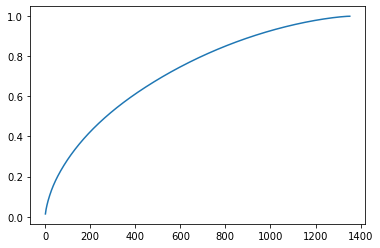

In [58]:
sns.lineplot(x = range(1, len(tsvd.explained_variance_ratio_.cumsum()) + 1), 
             y = tsvd.explained_variance_ratio_.cumsum())

In [36]:
# Apply PCA
pca = PCA(n_components = 5)
pca.fit(X_prep)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.